In [1]:
pip install tensorflow opencv-python


Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# Load CIFAR-10 dataset
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()

# Normalize the images between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Add noise to the images
noise_factor = 0.4
noisy_x_train = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
noisy_x_test = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip the noisy images to stay within the range [0, 1]
noisy_x_train = np.clip(noisy_x_train, 0., 1.)
noisy_x_test = np.clip(noisy_x_test, 0., 1.)


In [3]:
def unet_model(input_size=(32, 32, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = Conv2D(512, (2, 2), activation='relu', padding='same')(u6)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Conv2D(256, (2, 2), activation='relu', padding='same')(u7)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = Conv2D(128, (2, 2), activation='relu', padding='same')(u8)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = Conv2D(64, (2, 2), activation='relu', padding='same')(u9)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

# Instantiate the model
model = unet_model()

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 32, 32, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 32, 32, 64)        │           1,792 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 32, 32, 64)        │          36,928 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 16, 16, 64)        │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 16, 16, 128)       │          73,856 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 16, 16, 128)       │         147,584 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 8, 8, 128)         │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 8, 8, 256)         │         295,168 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 8, 8, 256)         │         590,080 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 4, 4, 256)         │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 4, 4, 512)         │       1,180,160 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 4, 4, 512)         │       2,359,808 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 2, 2, 512)         │               0 │ conv2d_7[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 2, 2, 1024)        │       4,719,616 │ max_pooling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 2, 2, 1024)        │       9,438,208 │ conv2d_8[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d (UpSampling2D)  │ (None, 4, 4, 1024)        │               

 Total params: 31,031,875 (118.38 MB)

 Trainable params: 31,031,875 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Train the model using noisy images as input and clean images as the output
history = model.fit(noisy_x_train, x_train, epochs=20, batch_size=16, validation_data=(noisy_x_test, x_test))


Epoch 1/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1292s 411ms/step - accuracy: 0.6214 - loss: 0.0113 - val_accuracy: 0.7022 - val_loss: 0.0076
Epoch 2/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1212s 388ms/step - accuracy: 0.6878 - loss: 0.0076 - val_accuracy: 0.7030 - val_loss: 0.0075
Epoch 3/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1207s 386ms/step - accuracy: 0.6933 - loss: 0.0074 - val_accuracy: 0.7043 - val_loss: 0.0073
Epoch 4/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1217s 389ms/step - accuracy: 0.7005 - loss: 0.0072 - val_accuracy: 0.7144 - val_loss: 0.0072
Epoch 5/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1177s 377ms/step - accuracy: 0.7037 - loss: 0.0072 - val_accuracy: 0.7109 - val_loss: 0.0075
Epoch 6/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1141s 365ms/step - accuracy: 0.7067 - loss: 0.0071 - val_accuracy: 0.7036 - val_loss: 0.0071
Epoch 7/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1138s 364ms/step - accuracy: 0.7090 - loss: 0.0070 - val_accuracy: 0.7101 - val_loss: 0.0072
Epoch 8/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1141s 365ms/s

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step


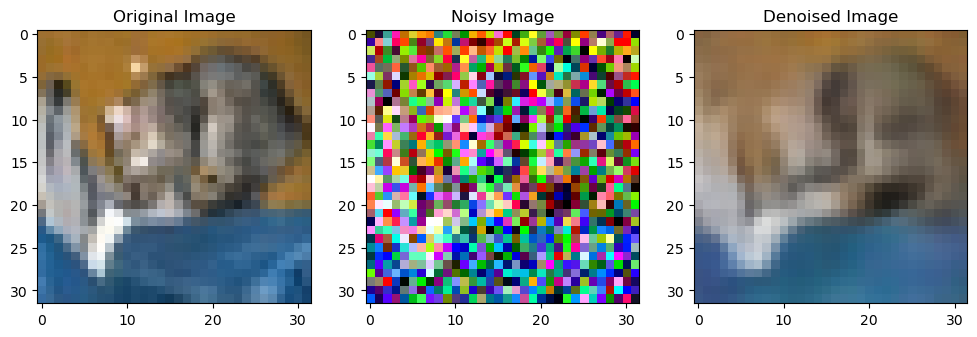

Model successfully saved to C:\Users\GrimDeath\Desktop\ImageDenoiseEnhanced.keras


In [7]:
import os
# Predict on a noisy test image
test_img = noisy_x_test[0]
denoised_img = model.predict(np.expand_dims(test_img, axis=0))

# Visualize the original, noisy, and denoised images
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(x_test[0])

plt.subplot(1, 3, 2)
plt.title('Noisy Image')
plt.imshow(test_img)

plt.subplot(1, 3, 3)
plt.title('Denoised Image')
plt.imshow(np.squeeze(denoised_img))
plt.show()

current_directory = os.getcwd()
model_save_path = os.path.join(current_directory, "ImageDenoiseEnhanced.keras")
model.save(model_save_path)
print(f"Model successfully saved to {model_save_path}")

In [5]:
# Load the saved model
model = tf.keras.models.load_model('ImageDenoiseEnhanced.keras')

# Continue training from where you left off
history = model.fit(noisy_x_train, x_train, epochs=30, initial_epoch=20, batch_size=16, validation_data=(noisy_x_test, x_test))


Epoch 21/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1271s 405ms/step - accuracy: 0.7114 - loss: 0.0070 - val_accuracy: 0.7189 - val_loss: 0.0070
Epoch 22/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1258s 402ms/step - accuracy: 0.7111 - loss: 0.0069 - val_accuracy: 0.7194 - val_loss: 0.0070
Epoch 23/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1205s 386ms/step - accuracy: 0.7125 - loss: 0.0069 - val_accuracy: 0.7129 - val_loss: 0.0071
Epoch 24/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1164s 372ms/step - accuracy: 0.7124 - loss: 0.0068 - val_accuracy: 0.7166 - val_loss: 0.0070
Epoch 25/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1219s 390ms/step - accuracy: 0.7126 - loss: 0.0068 - val_accuracy: 0.7122 - val_loss: 0.0069
Epoch 26/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1214s 388ms/step - accuracy: 0.7139 - loss: 0.0068 - val_accuracy: 0.6979 - val_loss: 0.0071
Epoch 27/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1165s 373ms/step - accuracy: 0.7149 - loss: 0.0068 - val_accuracy: 0.7045 - val_loss: 0.0070
Epoch 28/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1193s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


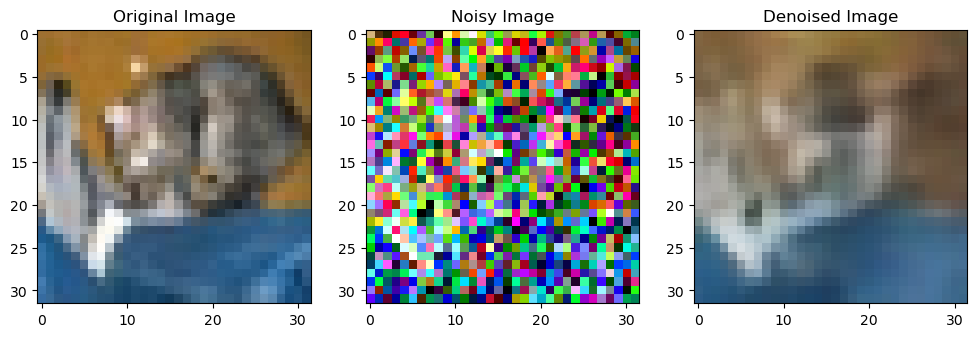

Model successfully saved to C:\Users\GrimDeath\Downloads\DIP-Project-main\DIP-Project-main\ImageDenoiseEnhanced.keras


In [7]:
import os
# Predict on a noisy test image
test_img = noisy_x_test[0]
denoised_img = model.predict(np.expand_dims(test_img, axis=0))

# Visualize the original, noisy, and denoised images
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(x_test[0])

plt.subplot(1, 3, 2)
plt.title('Noisy Image')
plt.imshow(test_img)

plt.subplot(1, 3, 3)
plt.title('Denoised Image')
plt.imshow(np.squeeze(denoised_img))
plt.show()

current_directory = os.getcwd()
model_save_path = os.path.join(current_directory, "ImageDenoiseEnhanced.keras")
model.save(model_save_path)
print(f"Model successfully saved to {model_save_path}")

In [3]:
# Load the saved model
model = tf.keras.models.load_model('ImageDenoiseEnhanced.keras')

# Continue training from where you left off
history = model.fit(noisy_x_train, x_train, epochs=40, initial_epoch=30, batch_size=16, validation_data=(noisy_x_test, x_test))

Epoch 31/40
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1158s 369ms/step - accuracy: 0.7101 - loss: 0.0070 - val_accuracy: 0.7175 - val_loss: 0.0070
Epoch 32/40
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1139s 364ms/step - accuracy: 0.7121 - loss: 0.0069 - val_accuracy: 0.7186 - val_loss: 0.0070
Epoch 33/40
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1137s 364ms/step - accuracy: 0.7133 - loss: 0.0069 - val_accuracy: 0.7175 - val_loss: 0.0069
Epoch 34/40
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1138s 364ms/step - accuracy: 0.7136 - loss: 0.0068 - val_accuracy: 0.6971 - val_loss: 0.0070
Epoch 35/40
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1139s 364ms/step - accuracy: 0.7129 - loss: 0.0068 - val_accuracy: 0.7116 - val_loss: 0.0069
Epoch 36/40
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1140s 365ms/step - accuracy: 0.7140 - loss: 0.0068 - val_accuracy: 0.7225 - val_loss: 0.0069
Epoch 37/40
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1140s 365ms/step - accuracy: 0.7152 - loss: 0.0067 - val_accuracy: 0.7033 - val_loss: 0.0069
Epoch 38/40
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1142s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


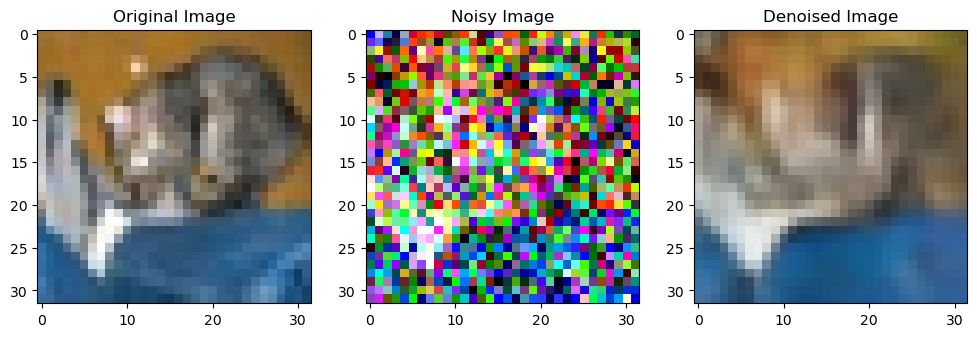

Model successfully saved to C:\Users\GrimDeath\Downloads\DIP-Project-main\DIP-Project-main\ImageDenoiseEnhanced.keras


In [5]:
import os
# Predict on a noisy test image
test_img = noisy_x_test[0]
denoised_img = model.predict(np.expand_dims(test_img, axis=0))

# Visualize the original, noisy, and denoised images
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(x_test[0])

plt.subplot(1, 3, 2)
plt.title('Noisy Image')
plt.imshow(test_img)

plt.subplot(1, 3, 3)
plt.title('Denoised Image')
plt.imshow(np.squeeze(denoised_img))
plt.show()

current_directory = os.getcwd()
model_save_path = os.path.join(current_directory, "ImageDenoiseEnhanced.keras")
model.save(model_save_path)
print(f"Model successfully saved to {model_save_path}")